# Exploración de los datos

Se hace un histograma de las emociones del dataset.

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dir_path = "data"
emotions = {
    "01": "neutral",
    "02": "calma",
    "03": "feliz",
    "04": "triste",
    "05": "enojado",
    "06": "temeroso",
    "07": "disgustado",
    "08": "sorprendido"
}

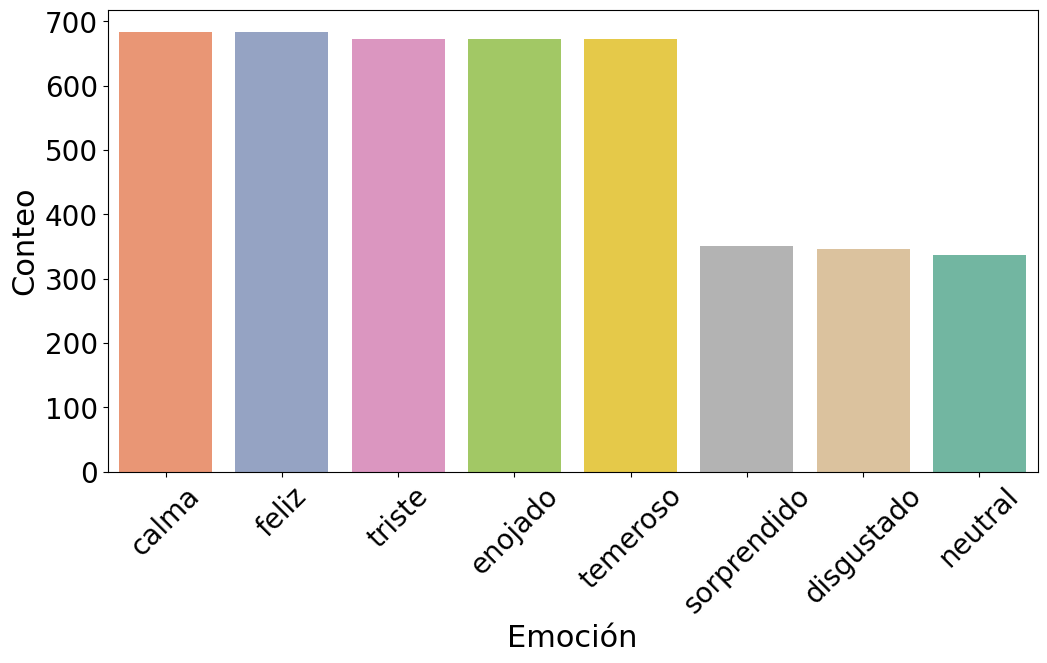

In [ ]:
emotion_list = []

for root, dirs, files in os.walk(dir_path):
    for file in files:
        if file.endswith('.wav'):
            emotion_code = file.split('-')[2]
            emotion = emotions[emotion_code]
            emotion_list.append(emotion)

df = pd.DataFrame(emotion_list, columns=["Emoción"])

plt.figure(figsize=(12, 6))
sns.countplot(x="Emoción", data=df, order=df["Emoción"].value_counts().index, hue="Emoción", palette="Set2", legend=False)
plt.xlabel("Emoción", fontsize=22)
plt.ylabel("Conteo", fontsize=22)
plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.show()

# Evaluaciones de Performance

## Modelo de CNN solo con Speech

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

seed_value = 32
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

train_dir = "data/spectrograms/speech"
test_dir = "data/spectrograms_test/speech"

img_width, img_height = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.125,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = tf.keras.preprocessing.image.DirectoryIterator(
    directory=train_dir,
    image_data_generator=train_datagen,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

def create_cnn_x_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(8, (3, 3), activation='relu')(inputs)
    x = AveragePooling2D((2, 2))(x)
    
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = AveragePooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = AveragePooling2D((2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)  
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)  
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

input_shape = (img_width, img_height, 3)
num_classes = 8
learning_rate = 0.0001  
momentum = 0.8
epochs = 50  

model = create_cnn_x_model(input_shape, num_classes)

optimizer = RMSprop(learning_rate=learning_rate, momentum=momentum)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs
)

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Found 67 images belonging to 1 classes.
Found 947 images belonging to 7 classes.
Found 1014 images belonging to 8 classes.
Found 142 images belonging to 8 classes.
Found 300 images belonging to 8 classes.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 111, 111, 8)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 54, 54, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 26, 26, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2048)           │    44,304,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,523,160 (185.10 MB)

 Trainable params: 48,523,160 (185.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


c:\Users\casti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 700ms/step - accuracy: 0.1459 - loss: 2.0721 - val_accuracy: 0.1328 - val_loss: 2.0614
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1250 - loss: 2.0374 - val_accuracy: 0.3571 - val_loss: 2.0476
Epoch 3/50


c:\Users\casti\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 701ms/step - accuracy: 0.1497 - loss: 2.0461 - val_accuracy: 0.2500 - val_loss: 1.9770
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0938 - loss: 2.1512 - val_accuracy: 0.2143 - val_loss: 1.9420
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 686ms/step - accuracy: 0.2663 - loss: 1.9073 - val_accuracy: 0.3516 - val_loss: 1.8451
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3125 - loss: 1.8395 - val_accuracy: 0.2857 - val_loss: 1.9037
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 661ms/step - accuracy: 0.2919 - loss: 1.7756 - val_accuracy: 0.3984 - val_loss: 1.7496
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3125 - loss: 1.7486 - val_accuracy: 0.1429 - val_loss: 2.1566
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 655ms/step - accuracy: 0.3387 - loss: 1.7180 - val_accuracy: 0.3125 - val_loss: 1.7435
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4375 - loss: 1.5684 - val_accuracy: 0.5000 - val_los

## Modelo de CNN combinando Speech y Song

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

seed_value = 32
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

train_dir = "data/spectrograms/combined"
test_dir = "data/spectrograms_test/combined"

img_width, img_height = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.125,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = tf.keras.preprocessing.image.DirectoryIterator(
    directory=train_dir,
    image_data_generator=train_datagen,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

def create_cnn_x_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(8, (3, 3), activation='relu')(inputs)
    x = AveragePooling2D((2, 2))(x)
    
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = AveragePooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = AveragePooling2D((2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)  
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)  
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

input_shape = (img_width, img_height, 3)
num_classes = 8
learning_rate = 0.0001  
momentum = 0.8
epochs = 50  

model = create_cnn_x_model(input_shape, num_classes)

optimizer = RMSprop(learning_rate=learning_rate, momentum=momentum)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs
)

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Found 1707 images belonging to 8 classes.
Found 241 images belonging to 8 classes.
Found 520 images belonging to 8 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 111, 111, 8)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 54, 54, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 26, 26, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │    44,304,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,523,160 (185.10 MB)

 Trainable params: 48,523,160 (185.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


c:\Users\casti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 733ms/step - accuracy: 0.1462 - loss: 2.0550 - val_accuracy: 0.1607 - val_loss: 2.0104
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0938 - loss: 1.9806 - val_accuracy: 0.0588 - val_loss: 2.1687
Epoch 3/50


c:\Users\casti\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 701ms/step - accuracy: 0.1654 - loss: 2.0165 - val_accuracy: 0.1830 - val_loss: 1.9757
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2188 - loss: 1.9064 - val_accuracy: 0.1176 - val_loss: 1.9734
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 698ms/step - accuracy: 0.2192 - loss: 1.9383 - val_accuracy: 0.2321 - val_loss: 1.9044
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1562 - loss: 1.7804 - val_accuracy: 0.1176 - val_loss: 2.0229
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 695ms/step - accuracy: 0.2889 - loss: 1.8466 - val_accuracy: 0.2812 - val_loss: 1.8960
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1250 - loss: 1.8336 - val_accuracy: 0.1176 - val_loss: 1.8939
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 713ms/step - accuracy: 0.3217 - loss: 1.7450 - val_accuracy: 0.2589 - val_loss: 1.9446
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2812 - loss: 1.7557 - val_accuracy: 0.4118 - val_los

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

seed_value = 32
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

class CNNModel:
    def __init__(self, train_dir, test_dir, img_width=224, img_height=224, batch_size=32, seed_value=32, learning_rate=0.0001, momentum=0.8, epochs=50):
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.img_width = img_width
        self.img_height = img_height
        self.batch_size = batch_size
        self.seed_value = seed_value
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.epochs = epochs
        self._prepare_data_generators()
        
        
    def _prepare_data_generators(self):
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.125,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
        )
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        self.train_generator = train_datagen.flow_from_directory(
            self.train_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='training'
        )
        
        self.val_generator = train_datagen.flow_from_directory(
            self.train_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='validation'
        )
        
        self.test_generator = test_datagen.flow_from_directory(
            self.test_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='categorical'
        )
        
    def create_model(self, input_shape, num_classes):
        inputs = Input(shape=input_shape)
        
        x = Conv2D(8, (3, 3), activation='relu')(inputs)
        x = AveragePooling2D((2, 2))(x)
        
        x = Conv2D(16, (3, 3), activation='relu')(x)
        x = AveragePooling2D((2, 2))(x)
        
        x = Conv2D(32, (3, 3), activation='relu')(x)
        x = AveragePooling2D((2, 2))(x)
        
        x = Flatten()(x)
        x = Dense(2048, activation='relu')(x)
        x = Dropout(0.5)(x)  
        x = Dense(2048, activation='relu')(x)
        x = Dropout(0.5)(x)  
        outputs = Dense(num_classes, activation='softmax')(x)
        
        self.model = Model(inputs, outputs)
        
    def compile_model(self):
        optimizer = RMSprop(learning_rate=self.learning_rate, momentum=self.momentum)
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        
    def train_model(self):
        self.history = self.model.fit(
            self.train_generator,
            steps_per_epoch=self.train_generator.samples // self.batch_size,
            validation_data=self.val_generator,
            validation_steps=self.val_generator.samples // self.batch_size,
            epochs=self.epochs
        )
        
    def evaluate_model(self):
        test_loss, test_accuracy = self.model.evaluate(self.test_generator, steps=self.test_generator.samples // self.batch_size)
        print(f"Test accuracy: {test_accuracy * 100:.2f}%")
        
    def summary(self):
        self.model.summary()

if __name__ == "__main__":
    train_dir = "data/spectrograms/combined"
    test_dir = "data/spectrograms_test/combined"
    input_shape = (224, 224, 3)
    num_classes = 8
    
    cnn_model = CNNModel(train_dir, test_dir)
    cnn_model.create_model(input_shape, num_classes)
    cnn_model.compile_model()
    cnn_model.summary()
    cnn_model.train_model()
    cnn_model.evaluate_model()


Found 1707 images belonging to 8 classes.
Found 241 images belonging to 8 classes.
Found 520 images belonging to 8 classes.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 111, 111, 8)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 54, 54, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_8             │ (None, 26, 26, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2048)           │    44,304,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,523,160 (185.10 MB)

 Trainable params: 48,523,160 (185.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


c:\Users\casti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 782ms/step - accuracy: 0.1525 - loss: 2.0731 - val_accuracy: 0.2098 - val_loss: 2.0422
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3125 - loss: 1.9335 - val_accuracy: 0.1176 - val_loss: 1.9417
Epoch 3/50


c:\Users\casti\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 756ms/step - accuracy: 0.2646 - loss: 1.8804 - val_accuracy: 0.2812 - val_loss: 1.8301
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2500 - loss: 1.8805 - val_accuracy: 0.4118 - val_loss: 1.7425
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 738ms/step - accuracy: 0.3327 - loss: 1.7184 - val_accuracy: 0.3661 - val_loss: 1.7076
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4375 - loss: 1.5379 - val_accuracy: 0.2941 - val_loss: 1.8769
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 725ms/step - accuracy: 0.3863 - loss: 1.5948 - val_accuracy: 0.2768 - val_loss: 1.8893
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3125 - loss: 1.6068 - val_accuracy: 0.4706 - val_loss: 1.5453
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 749ms/step - accuracy: 0.3942 - loss: 1.5389 - val_accuracy: 0.2589 - val_loss: 1.9321
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4062 - loss: 1.3852 - val_accuracy: 0.3529 - val_los

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

seed_value = 32
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

class CNNModel:
    def __init__(self, train_dir, test_dir, img_width=224, img_height=224, batch_size=32, seed_value=32, learning_rate=0.0001, momentum=0.8, epochs=50):
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.img_width = img_width
        self.img_height = img_height
        self.batch_size = batch_size
        self.seed_value = seed_value
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.epochs = epochs
        self._prepare_data_generators()
        
        
    def _prepare_data_generators(self):
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.125,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
        )
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        self.train_generator = train_datagen.flow_from_directory(
            self.train_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='training'
        )
        
        self.val_generator = train_datagen.flow_from_directory(
            self.train_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='validation'
        )
        
        self.test_generator = test_datagen.flow_from_directory(
            self.test_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='categorical'
        )
        
    def create_model(self, input_shape, num_classes):
        inputs = Input(shape=input_shape)
        
        x = Conv2D(8, (3, 3), activation='relu')(inputs)
        x = AveragePooling2D((2, 2))(x)
        
        x = Conv2D(16, (3, 3), activation='relu')(x)
        x = AveragePooling2D((2, 2))(x)
        
        x = Conv2D(32, (3, 3), activation='relu')(x)
        x = AveragePooling2D((2, 2))(x)
        
        x = Flatten()(x)
        x = Dense(2048, activation='relu')(x)
        x = Dropout(0.5)(x)  
        x = Dense(2048, activation='relu')(x)
        x = Dropout(0.5)(x)  
        outputs = Dense(num_classes, activation='softmax')(x)
        
        self.model = Model(inputs, outputs)
        
    def compile_model(self):
        optimizer = RMSprop(learning_rate=self.learning_rate, momentum=self.momentum)
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        
    def train_model(self):
        self.history = self.model.fit(
            self.train_generator,
            steps_per_epoch=self.train_generator.samples // self.batch_size,
            validation_data=self.val_generator,
            validation_steps=self.val_generator.samples // self.batch_size,
            epochs=self.epochs
        )
        
    def evaluate_model(self):
        test_loss, test_accuracy = self.model.evaluate(self.test_generator, steps=self.test_generator.samples // self.batch_size)
        print(f"Test accuracy: {test_accuracy * 100:.2f}%")
        
    def summary(self):
        self.model.summary()


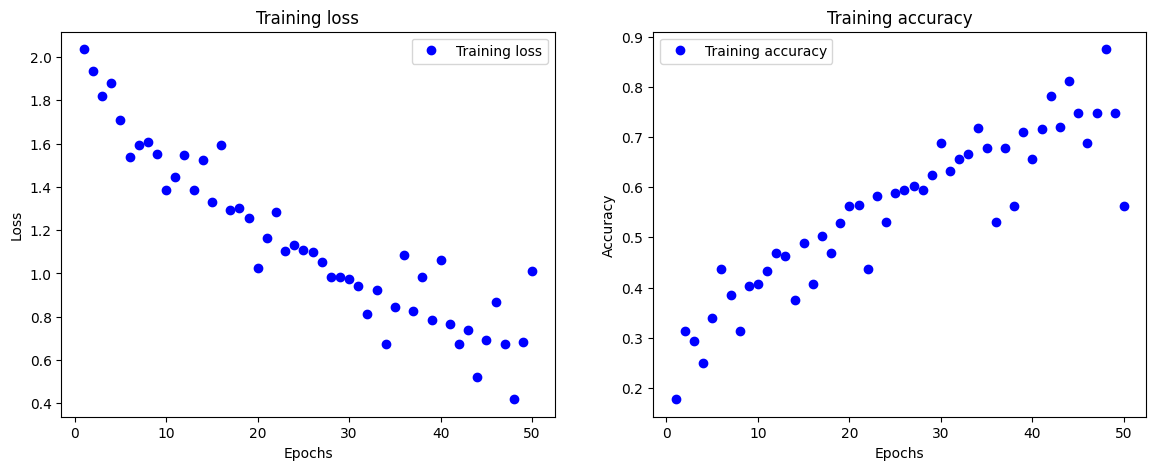

In [9]:
import matplotlib.pyplot as plt

history_dict = cnn_model.history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, "bo", label="Training loss")
# plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
# plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [ ]:
import os
import time
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
from imblearn.over_sampling import SMOTE
from collections import Counter
import librosa
from pydub import AudioSegment
from pydub.silence import split_on_silence
from sklearn.model_selection import GroupShuffleSplit, KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, LSTM, RepeatVector, TimeDistributed, Reshape
from keras.models import Model, Sequential
from keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import opensmile
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
import seaborn as sns
import torch

In [ ]:
from src.models import lstm, RandomForest, autoencoder_lstm
from src.data_loader import DataLoader

In [ ]:
def plot_distribution(y, title):
    counts, bins = np.histogram(y, bins=8, range=(1, 9))
    bin_centers = np.arange(1, 9)
    plt.bar(bin_centers, counts, width=0.9, align='center')
    plt.xticks(range(1, 9))
    plt.title(title)
    plt.xlabel("Clases")
    plt.ylabel("Muestras")
    plt.show()


def one_hot_encoder(y):
    enc = OneHotEncoder(sparse_output=False)  
    return enc.fit_transform(y.reshape(-1, 1)) 


def normalization(X):
    scaler = StandardScaler()
    X_shape = X.shape
    if len(X_shape) == 3:
        X_reshaped = X.reshape(-1, X.shape[-1])
        X_scaled = scaler.fit_transform(X_reshaped)
        X = X_scaled.reshape(X_shape[0], X_shape[1], X_shape[2])
        return X
    else:
        print("Debería ser dimenison 3")

def SMOTE_(X, y):
    x_shape = X.shape
    if len(x_shape) ==3:
        X = X.reshape((x_shape[0], -1))
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)
    if len(x_shape) == 3:
        X = X.reshape((-1, x_shape[1], x_shape[2]))
    return X, y


In [ ]:
DL = DataLoader()

se inicializo


In [ ]:
speech1_dataset_dev = "data/1frame_Speech_dataset_dev.npy"
speech2_dataset_dev = "data/2frame_Speech_dataset_dev.npy"
speech3_dataset_dev = "data/3frame_Speech_dataset_dev.npy"
speech4_dataset_dev = "data/4frame_Speech_dataset_dev.npy"
speech8_dataset_dev = "data/8frame_Speech_dataset_dev.npy"
speech10_dataset_dev = "data/10frame_Speech_dataset_dev.npy"
speech16_dataset_dev = "data/16frame_Speech_dataset_dev.npy"
song1_dataset_dev = "data/1frame_Song_dataset_dev.npy"
song2_dataset_dev = "data/2frame_Song_dataset_dev.npy"
song3_dataset_dev = "data/3frame_Song_dataset_dev.npy"
song4_dataset_dev = "data/4frame_Song_dataset_dev.npy"
song8_dataset_dev = "data/8frame_Song_dataset_dev.npy"
song10_dataset_dev = "data/10frame_Song_dataset_dev.npy"
song16_dataset_dev = "data/16frame_Song_dataset_dev.npy"

speech1_dataset_test = "data/1frame_Speech_dataset_test.npy"
speech2_dataset_test = "data/2frame_Speech_dataset_test.npy"
speech3_dataset_test = "data/3frame_Speech_dataset_test.npy"
speech4_dataset_test = "data/4frame_Speech_dataset_test.npy"
speech8_dataset_test = "data/8frame_Speech_dataset_test.npy"
speech10_dataset_test = "data/10frame_Speech_dataset_test.npy"
speech16_dataset_test = "data/16frame_Speech_dataset_test.npy"
song1_dataset_test = "data/1frame_Song_dataset_test.npy"
song2_dataset_test = "data/2frame_Song_dataset_test.npy"
song3_dataset_test = "data/3frame_Song_dataset_test.npy"
song4_dataset_test = "data/4frame_Song_dataset_test.npy"
song8_dataset_test = "data/8frame_Song_dataset_test.npy"
song10_dataset_test = "data/10frame_Song_dataset_test.npy"
song16_dataset_test = "data/16frame_Song_dataset_test.npy"

path_speech_dev = r"data\data_dev\speech\*\*"
path_song_dev = r"data\data_dev\song\*\*"
path_speech_test = r"data/data_test/speech/*/*"
path_song_test = r"data/data_test/song/*/*"

In [ ]:
DL.process_dataset(path_song_dev, song10_dataset_dev, 10)
DL.process_dataset(path_speech_dev, speech10_dataset_dev, 10)
DL.process_dataset(path_song_test, song10_dataset_test, 10)
DL.process_dataset(path_speech_test, speech10_dataset_test, 10)

## RNN: LSTM

data/10frame_Song_actors_dev.npy
X shape (1948, 10, 88)
y shape (1948,)
actors shape (1948,)
data/10frame_Song_actors_test.npy
X shape (520, 10, 88)
y shape (520,)
actors shape (520,)
Distribución de clases antes de SMOTE train: Counter({3: 238, 2: 238, 4: 232, 5: 232, 6: 232, 8: 123, 7: 121, 1: 116})
Distribución de clases antes de SMOTE valid: Counter({2: 64, 3: 64, 4: 64, 6: 64, 5: 64, 7: 32, 1: 32, 8: 32})
Distribución de clases antes de SMOTE test: Counter({2: 80, 3: 80, 4: 80, 5: 80, 6: 80, 1: 40, 7: 40, 8: 40})


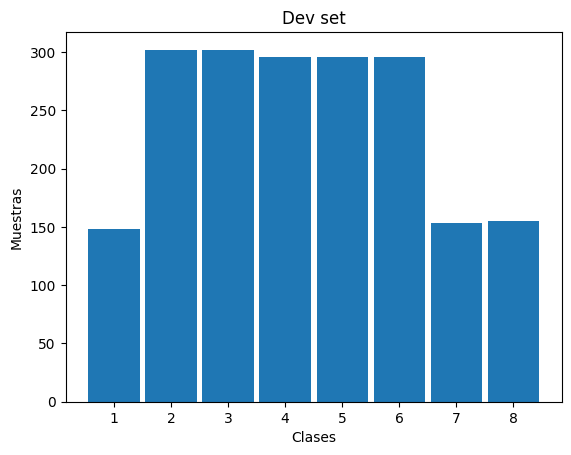

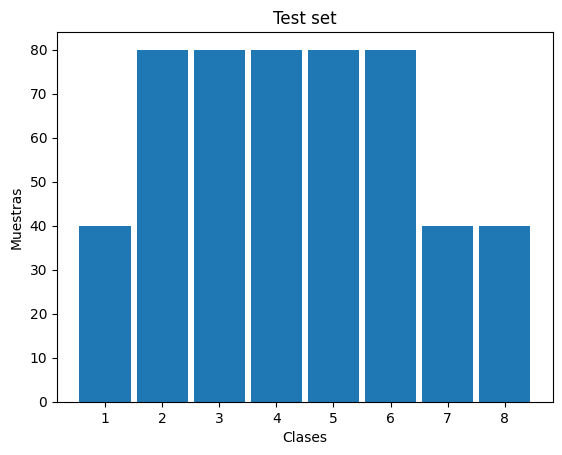

Distribución de clases despues de SMOTE train: Counter({7: 238, 4: 238, 8: 238, 3: 238, 5: 238, 1: 238, 6: 238, 2: 238})
Distribución de clases despues de SMOTE train: Counter({2: 64, 3: 64, 4: 64, 6: 64, 5: 64, 7: 32, 1: 32, 8: 32})
Distribución de clases despues de SMOTE train: Counter({2: 80, 3: 80, 4: 80, 5: 80, 6: 80, 1: 40, 7: 40, 8: 40})
s
(1904, 10, 88)
(416, 10, 88)


In [ ]:
X_dev, y_dev, actors_dev = DL.get_dataset([song10_dataset_dev, speech10_dataset_dev], 10)
X_train, X_valid, y_train, y_valid, actors_train, actors_valid = DL.split_dataset(X_dev, y_dev, test_size=0.2, actors=actors_dev)
X_test, y_test, actors_test = DL.get_dataset([song10_dataset_test, speech10_dataset_test], 10)

print('Distribución de clases antes de SMOTE train:', Counter(y_train))
print('Distribución de clases antes de SMOTE valid:', Counter(y_valid))
print('Distribución de clases antes de SMOTE test:', Counter(y_test))

plot_distribution(y_dev, "Dev set")
plot_distribution(y_test, "Test set")

X_train, y_train = SMOTE_(X_train, y_train)

print('Distribución de clases despues de SMOTE train:', Counter(y_train))
print('Distribución de clases despues de SMOTE train:', Counter(y_valid))
print('Distribución de clases despues de SMOTE train:', Counter(y_test))

print("s")
print(X_train.shape)
print(X_valid.shape)

X_train = normalization(X_train)
X_valid = normalization(X_valid)
X_test = normalization(X_test)

y_train_ohe  = one_hot_encoder(y_train)
y_valid_ohe = one_hot_encoder(y_valid)
y_test_ohe = one_hot_encoder(y_test)
y_dev_ohe = one_hot_encoder(y_dev)

Epoch 1/40
60/60 [==============================] - 1s 9ms/step - loss: 0.9711 - val_loss: 0.8603
Epoch 2/40
60/60 [==============================] - 0s 7ms/step - loss: 0.7993 - val_loss: 0.7572
Epoch 3/40
60/60 [==============================] - 1s 8ms/step - loss: 0.7224 - val_loss: 0.7079
Epoch 4/40
60/60 [==============================] - 1s 10ms/step - loss: 0.6811 - val_loss: 0.6761
Epoch 5/40
60/60 [==============================] - 1s 11ms/step - loss: 0.6495 - val_loss: 0.6542
Epoch 6/40
60/60 [==============================] - 1s 11ms/step - loss: 0.6289 - val_loss: 0.6399
Epoch 7/40
60/60 [==============================] - 0s 5ms/step - loss: 0.6144 - val_loss: 0.6301
Epoch 8/40
60/60 [==============================] - 0s 5ms/step - loss: 0.6027 - val_loss: 0.6205
Epoch 9/40
60/60 [==============================] - 0s 6ms/step - loss: 0.5910 - val_loss: 0.6132
Epoch 10/40
60/60 [==============================] - 0s 4ms/step - loss: 0.5828 - val_loss: 0.6080
Epoch 11/40
60/6

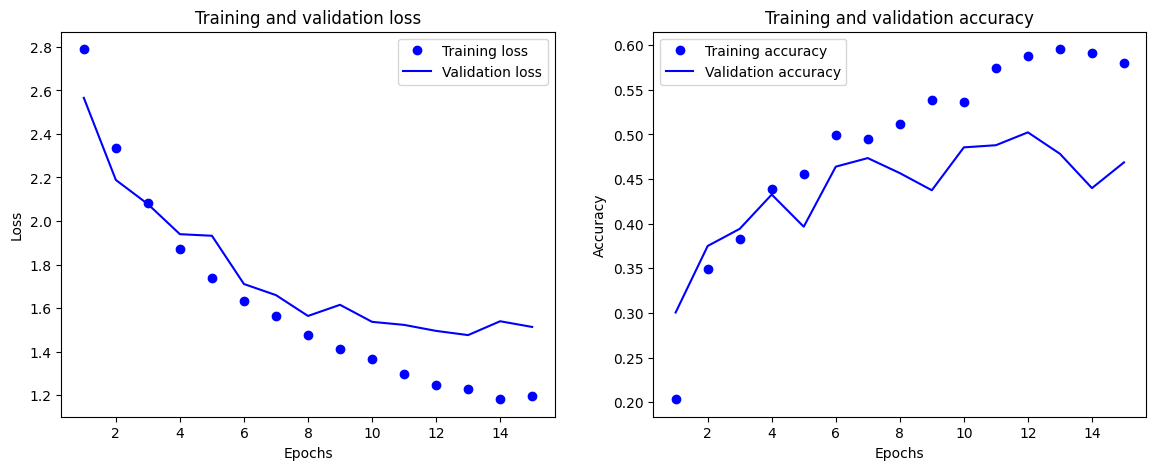

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (n_time_segments, features)
lstm_autoencoder_rnn = autoencoder_lstm.LSTM_Autoencoder_RNN(input_shape=input_shape)
lstm_autoencoder_rnn.train_autoencoder(X_train, X_valid)

X_train_encoded = lstm_autoencoder_rnn.transform(X_train)
X_valid_encoded = lstm_autoencoder_rnn.transform(X_valid)
X_test_encoded = lstm_autoencoder_rnn.transform(X_test)
print(X_train_encoded.shape)

lstm_autoencoder_rnn.train_rnn(X_train_encoded, y_train_ohe, X_valid_encoded, y_valid_ohe)
lstm_autoencoder_rnn.plot_learning_curves()


In [ ]:
print("test")

test_loss, test_accuracy = lstm_autoencoder_rnn.evaluate_rnn(X_test_encoded, y_test_ohe)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

test
17/17 [==============================] - 1s 9ms/step - loss: 1.5718 - accuracy: 0.4423
Test loss: 1.5718039274215698, Test accuracy: 0.4423076808452606


### Cross validation: RNN

In [ ]:

def cross_validate_rnn(X, y, groups, n_splits=5, epochs=100, batch_size=32, learning_rate = 0.001, dropout = 0.5, momentum =0.9):
    valid_loss = []
    gkf = GroupKFold(n_splits=n_splits)
    fold_no = 1
    print(y.shape)
    for train_index, val_index in gkf.split(X, y, groups):
        print(f'Training fold {fold_no} ...')
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        X_train, y_train = shuffle(X_train, y_train, random_state=42)
        X_val, y_val = shuffle(X_val, y_val, random_state=42)

        print(y_train)
        print(X_train.shape)
        print(y_train.shape)
        print(X_val.shape)
        print(y_val.shape)
        model = lstm.rnnLSTM(X_train, y_train, lr= learning_rate, dropout_rate=dropout, momentum=momentum)
        model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)

        val_loss, val_accuracy = model.evaluate(X_val, y_val)
        print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        valid_loss.append(val_loss)
        fold_no += 1
    return np.mean(valid_loss)



In [ ]:
batches_size = [32, 64]
lrs = [0.001, 0.01]
dropout = [0.2, 0.5]
momentum = [0.7, 0.9]

hyperparams = list(itertools.product(batches_size, lrs, dropout, momentum))
print(y_dev_ohe.shape)

valid_loss = []
for i in tqdm(range(len(hyperparams))):
    batch_s, lr, drop, moment = hyperparams[i]
    loss = cross_validate_rnn(X_dev, y_dev_ohe, actors_dev, batch_size=batch_s, learning_rate=lr, dropout=drop, momentum=moment)
    valid_loss.append(loss)


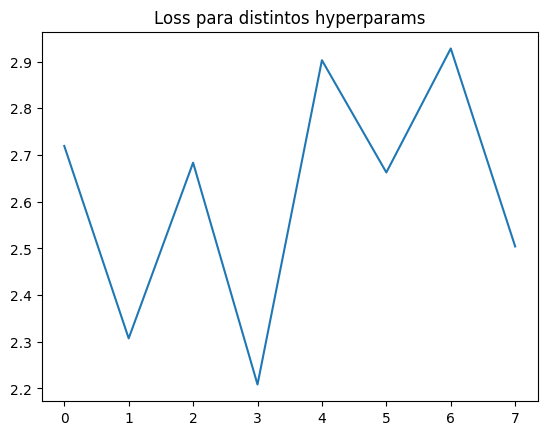

opt hyperparams:  (32, 0.001, 0.5, 0.9)
min val loss: 2.2084054946899414


In [ ]:
plt.plot(range(len(valid_loss)), valid_loss)
plt.title("Loss para distintos hyperparams")
plt.show()

print("opt hyperparams: ", hyperparams[np.argmin(valid_loss)])
print("min val loss:", np.min(valid_loss))

In [ ]:
RNN_hyperparams_save_path = "configs/data/RNN_hyperparameters.npy" 
np.save(RNN_hyperparams_save_path, hyperparams[np.argmin(valid_loss)])


train
cambio
Epoch 1/500
60/60 [==============================] - 5s 26ms/step - loss: 2.9620 - accuracy: 0.1271 - val_loss: 2.8423 - val_accuracy: 0.1827
Epoch 2/500
60/60 [==============================] - 1s 24ms/step - loss: 2.8524 - accuracy: 0.1922 - val_loss: 2.7687 - val_accuracy: 0.2644
Epoch 3/500
60/60 [==============================] - 2s 26ms/step - loss: 2.7657 - accuracy: 0.2216 - val_loss: 2.7053 - val_accuracy: 0.3029
Epoch 4/500
60/60 [==============================] - 2s 36ms/step - loss: 2.6912 - accuracy: 0.2647 - val_loss: 2.6456 - val_accuracy: 0.3389
Epoch 5/500
60/60 [==============================] - 1s 16ms/step - loss: 2.6312 - accuracy: 0.2878 - val_loss: 2.5904 - val_accuracy: 0.3534
Epoch 6/500
60/60 [==============================] - 1s 16ms/step - loss: 2.5707 - accuracy: 0.3141 - val_loss: 2.5363 - val_accuracy: 0.3630
Epoch 7/500
60/60 [==============================] - 2s 37ms/step - loss: 2.5211 - accuracy: 0.3288 - val_loss: 2.4849 - val_accuracy: 

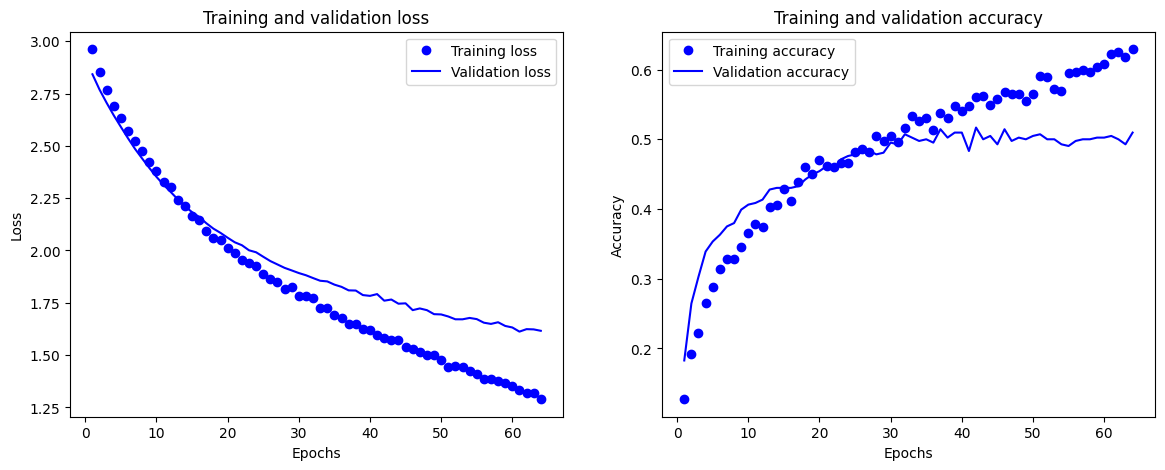

In [ ]:
print("train")
RNN_hyperparams_save_path = "configs/data/RNN_hyperparameters.npy" 
hyperparams = np.load(RNN_hyperparams_save_path)

R = rnnLSTM(X_train, y_train_ohe, lr=hyperparams[1], dropout_rate=hyperparams[2], patience=3, momentum=hyperparams[3])
R.train(X_train, y_train_ohe, X_valid, y_valid_ohe, epochs=500, batch_size=int(hyperparams[0]))
R.plot_learning_curves()

In [ ]:
print("test")
test_loss, test_accuracy = R.evaluate(X_test, y_test_ohe)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

test
17/17 [==============================] - 0s 10ms/step - loss: 1.6488 - accuracy: 0.4558
Test Loss: 1.6488455533981323
Test Accuracy: 0.45576924085617065
